# Star spots, stellar rotation, and the age distribution of the Galactic disk
## Technical Components
* Gaussian Processes; Theory and Implemntation
* Efficient Gaussian Process Packages in Python
* Model Selection; Cross Validation
* Hyperparameter Tuning; MCMC
* Algorithmic Complexity; "Big O" Notation
* Managing Memory Usage
* Stellar Ages; Gyrochronology

In [1]:
import astropy.units as u
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astropy.stats import LombScargle

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import seaborn as sns; sns.set()
import gc
import read_mist_models

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install george

You are using pip version 9.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -e git+https://github.com/dfm/kplr#egg=kplr-dev

Obtaining kplr from git+https://github.com/dfm/kplr#egg=kplr-dev
  Updating /srv/app/venv/src/kplr clone
  Found existing installation: kplr 0.2.2
    Uninstalling kplr-0.2.2:
      Successfully uninstalled kplr-0.2.2
  Running setup.py develop for kplr
You are using pip version 9.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Problem 1

## (a) 

Simulate a fake dataset with N = 20 datapoints. Assume that your true signal is given by a model y = sin(t) + cos(2t). Choose N random observation times, distributed uniformly over 0 < t < N/2. Assign each point a random uncertainty σy, drawn from a uniform distribution 0 < σy < 0.5. Throughout this lab, use a fixed random seed so that your results are reproducible. Make a plot of your synthetic data and the true model over 0 < t < N/2.

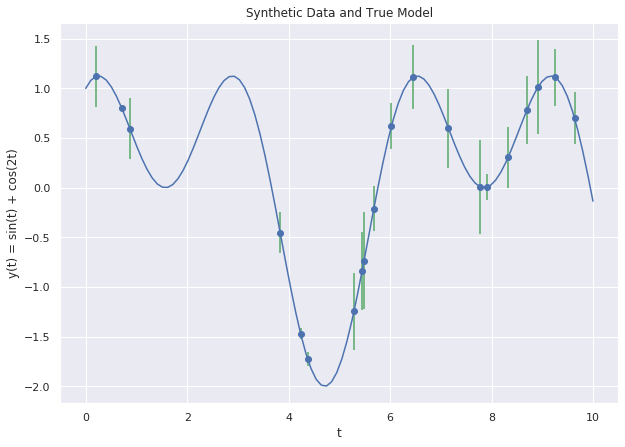

In [5]:
N = 20
rnd = np.random.seed(seed=0)
t = np.random.uniform(0, N/2, N)
sig = np.random.uniform(0, 0.5, N)
tx = np.linspace(0, N/2, 100)

def y(t):
    y = np.sin(t) + np.cos(2*t)
    return y

plt.figure(figsize=(10,7))
plt.errorbar(t, y(t), yerr = sig, fmt='o', ecolor='g', capthick=2, label = 'Synthetic Data')
plt.plot(tx, y(tx), label = 'True Model')
plt.xlabel('t')
plt.ylabel('y(t) = sin(t) + cos(2t)')
plt.title('Synthetic Data and True Model')
plt.show()

## (b)  
Build a naive Gaussian process model from scratch, and use it to predict the values of y(t) over 0 < t < 10 (on a finely sampled grid) based on the 10 datapoints.  Plot the predictions of your Gaussian process model, including the ±1 σ uncertainties, on top of the data and true model. Comment on the model’s performance. Does the true model prediction generally fall within the uncertainties

In [6]:
# http://krasserm.github.io/2018/03/19/gaussian-processes/

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

In [7]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=sig):

    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

In [8]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1, label = 'Model $\pm 1 \sigma$')
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx', label = 'Synthetic Data')
    plt.legend()


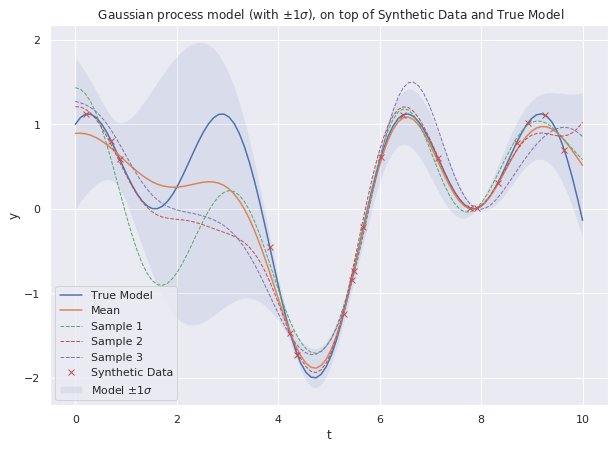

In [9]:
# Noise free training data
X_train = np.array(sorted(t)).reshape(-1, 1)
Y_train = y(X_train)
X = tx.reshape(-1, 1)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

plt.figure(figsize=(10,7))
plt.plot(tx, y(tx), label = 'True Model')
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.xlabel('t')
plt.ylabel('y')
plt.title(' Gaussian process model (with $\pm 1 \sigma$), on top of Synthetic Data and True Model')

plt.show()

As seen in the figure above, the true model prediction does fall within the uncertainties. The models performance does generally well as the true model falls within the uncertainties and the model prediction only yields large uncertainties in one area whereas it is fairly accurate everywhere else. 

## (c) 
Now try varying the correlation length l in your kernel function. Try l = 0.2, l = 1, and l = 5, and
make a plot comparing the data, GP model, and true model for both cases. Comment on your results.
Does this give you a sense of what the “best” value of l is

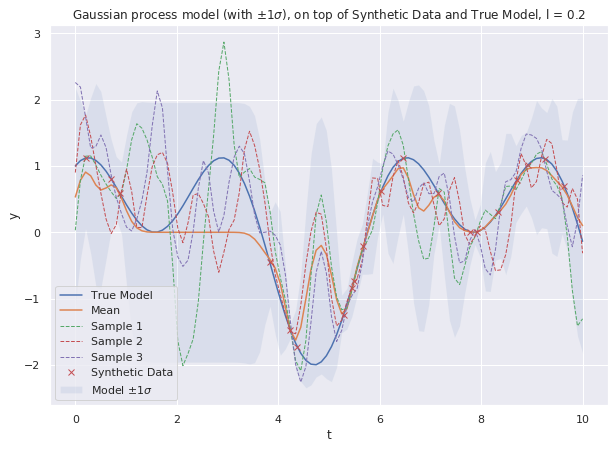

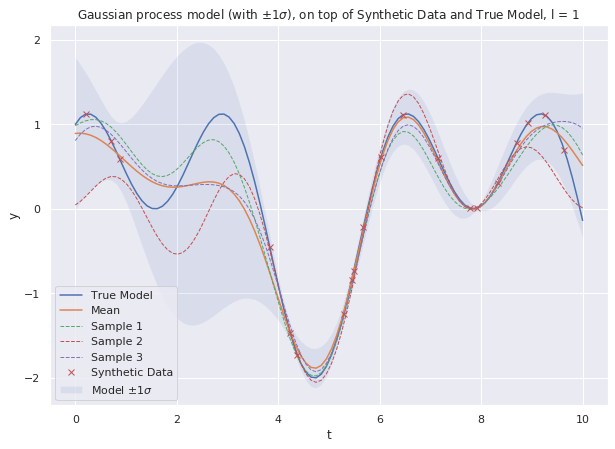

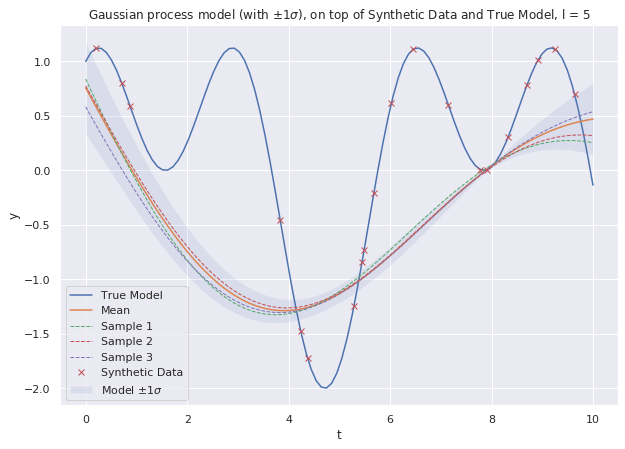

In [10]:
# Noise free training data
X_train = np.array(sorted(t)).reshape(-1, 1)
Y_train = y(X_train)
X = tx.reshape(-1, 1)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l = 0.2)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

plt.figure(figsize=(10,7))

plt.plot(tx, y(tx), label = 'True Model')
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Gaussian process model (with $\pm 1 \sigma$), on top of Synthetic Data and True Model, l = 0.2')

plt.show()

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l = 1)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

plt.figure(figsize=(10,7))

plt.plot(tx, y(tx), label = 'True Model')
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Gaussian process model (with $\pm 1 \sigma$), on top of Synthetic Data and True Model, l = 1')

plt.show()

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l = 5)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)

plt.figure(figsize=(10,7))

plt.plot(tx, y(tx), label = 'True Model')
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)
plt.xlabel('t')
plt.ylabel('y')
plt.title('Gaussian process model (with $\pm 1 \sigma$), on top of Synthetic Data and True Model, l = 5')

plt.show()

As seen in my figures above, l = 0.2 seems to overfit the data, as in the true model prediction will easily vary. l = 5 seems to underfit the data, as the true model prediction does not vary enough. l = 1 seems to be the 'best' value as it varies 'just right' to our data.

## (d) 
To be more quantitative, we’ll use cross-validation to choose the value of l. Generate another 10
datapoints to use as a validation set. Now try a log-spaced grid of 50 l values between 0.1 and 10. Plot this loss as a function of l. Comment on this behavior. What does this suggest is the "best" value of l?

In [11]:
def cv_loss(y_gp, y_obs, sig_gp, sig_obs):
    
    return np.mean(((y_gp - y_obs)**2)/(sig_obs**2 + sig_gp**2))

In [12]:
l_list = np.logspace(-1, 1, num = 50, base = 10) # gives values between 0.1 and 10
N = 20 # new datapoints
rnd = np.random.seed(seed=1)
t_obs = np.random.uniform(0, 10, N)
y_obs = y(t_obs)
sig_obs = np.random.uniform(0, 0.5, N)
tx = np.linspace(0, 10, N)

# Noise free training data
X_train = np.array(sorted(t_obs)).reshape(-1, 1)
Y_train = y(X_train)

X = tx.reshape(-1, 1)

cv_loss_list = []

for l in l_list:
    
    # Compute mean and covariance of the posterior predictive distribution
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l = l, sigma_y = sig_obs)

    samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
    uncertainty = 1.96 * np.sqrt(np.diag(cov_s))
    
    cv_loss_list.append(cv_loss(mu_s.ravel(), Y_train, uncertainty, sig_obs))

Text(0.5, 1.0, 'Loss as a function of l')

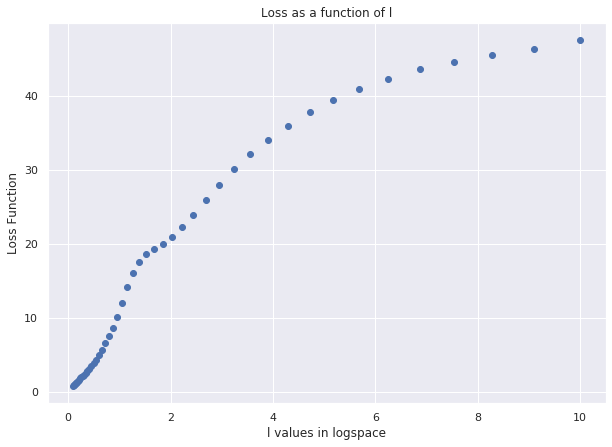

In [13]:
plt.figure(figsize = (10,7))
plt.scatter(l_list, cv_loss_list)
plt.xlabel('l values in logspace')
plt.ylabel('Loss Function')
plt.title('Loss as a function of l')

According to the graph above, it seems as though values giving the best (lowest) chisquare values are the lowest values (~0.1). I know, however, that these are not the best l values because my GP models in the part above show that l = 1 is clearly the best (fits closest to the true model).

## (e) 
Now check out the python GP package George. Discuss the possible advantages of using George over
own GP implementation. Use George to implement a GP model with an exponential-squared kernel
and l = 1. Verify that it gives identical model predictions and uncertainties to your explicit model in
part (b). Now repeat this, but using the “HODLRSolver” in George

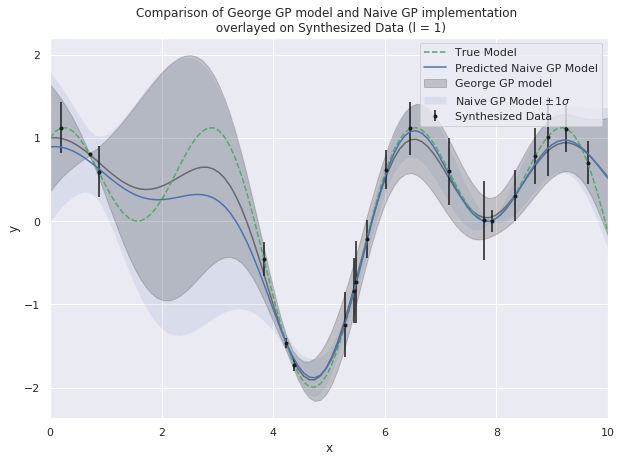

In [14]:
from george import kernels
import george

N = 20
rnd = np.random.seed(seed=0)
t = np.random.uniform(0, N/2, N)
sig = np.random.uniform(0, 0.5, N)
tx = np.linspace(0, N/2, 100)

# set up for naive GP model
X_train = np.array(sorted(t)).reshape(-1, 1)
Y_train = y(X_train)
X = tx.reshape(-1, 1)
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l = 1, sigma_y = sig)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
X = X.ravel()
mu = mu_s.ravel()
uncertainty = 1.96*np.sqrt(np.diag(cov_s))

# set up for George GP model
kernels = np.var(y(t)) * kernels.ExpSquaredKernel(1.0)
gp = george.GP(kernels)
gp.compute(t, sig)

x_pred = tx
pred, pred_var = gp.predict(y(t), x_pred, return_var=True)
err = 1.96*np.sqrt(pred_var)

plt.figure(figsize=(10,7))

plt.fill_between(x_pred, pred - err, pred + err,
                color="k", alpha=0.2, label = 'George GP model')
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(t, y(t), yerr=sig, fmt=".k", capsize=0, label = 'Synthesized Data')
plt.plot(x_pred, np.sin(x_pred) + np.cos(2*x_pred), "--g", label = 'True Model')

plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1, label = 'Naive GP Model $\pm 1 \sigma$')
plt.plot(X, mu, label= 'Predicted Naive GP Model')
    

plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Comparison of George GP model and Naive GP implementation \n overlayed on Synthesized Data (l = 1)")
plt.legend()
plt.show()

As seen in the figure above, my George GP model is not exactly the same as my naive GP model, however it is very close. The difference in these models is due to the difference in the way the GP models are using uncertainty. 

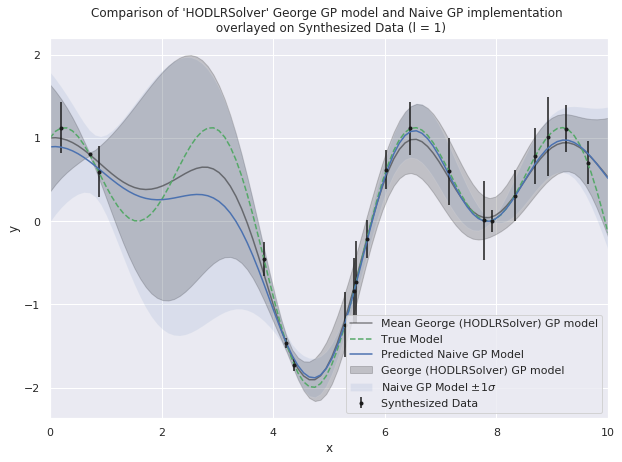

In [15]:
from george import kernels
#  Now repeat this, but using the “HODLRSolver” in George

# set up for George "HODLRSolver" GP model
kernels = np.var(y(t)) * kernels.ExpSquaredKernel(1)
gp = george.GP(kernels, solver=george.HODLRSolver)
gp.compute(t, sig)

x_pred = tx
hodlr_pred, hodlr_pred_var = gp.predict(y(t), x_pred, return_var=True)
hodlr_err = 1.96*np.sqrt(hodlr_pred_var)

plt.figure(figsize=(10,7))

plt.fill_between(x_pred, hodlr_pred - hodlr_err, hodlr_pred + hodlr_err,
                color="k", alpha=0.2, label = 'George (HODLRSolver) GP model')
plt.plot(x_pred, hodlr_pred, "k", lw=1.5, alpha=0.5, label = 'Mean George (HODLRSolver) GP model')
plt.errorbar(t, y(t), yerr=sig, fmt=".k", capsize=0, label = 'Synthesized Data')
plt.plot(x_pred, np.sin(x_pred) + np.cos(2*x_pred), "--g", label = 'True Model')

plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1, label = 'Naive GP Model $\pm 1 \sigma$')
plt.plot(X, mu, label= 'Predicted Naive GP Model')
    

plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Comparison of 'HODLRSolver' George GP model and Naive GP implementation \n overlayed on Synthesized Data (l = 1)")
plt.legend()
plt.show()

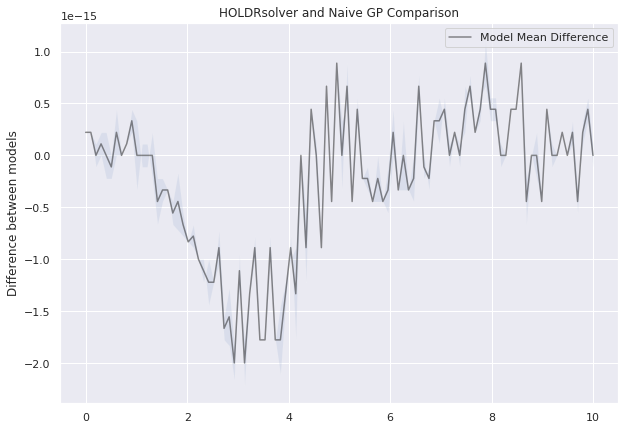

In [16]:
# plotting difference between basic George model and HODLRSolver George model
pred_diff = hodlr_pred - pred
pred_var_diff = hodlr_pred_var - pred_var
err_diff = hodlr_err - err

plt.figure(figsize=(10,7))
plt.plot(tx, pred_diff,"k", lw=1.5, alpha=0.5, label = 'Model Mean Difference')
plt.fill_between(tx, pred_diff + pred_var_diff, pred_diff - pred_var_diff, alpha=0.1)
plt.title('HOLDRsolver and Naive GP Comparison')
plt.ylabel('Difference between models')
plt.legend()
plt.show()

The basic George model and the HODLRSolver George model yield the similar results (note that the differences are scaled by 1e-15).

## (f) 
What happens when you increase the number of datapoints? Try log-spaced values of N between $2^0$
and $2^{13}$. Plot the total computational time required to evaluate the GP model as a function of N.
Compare three models: your naive GP, the default GP implementation in George, and George with the
HODLRSolver. Comment on the scalings with each model. Give a one-paragraph explanation what
George is doing that allows it to scale better than your naive GP implementation.

In [17]:
def naive_GP(t,tx):
    X_train = np.array(sorted(t)).reshape(-1, 1)
    Y_train = y(X_train)
    X = tx.reshape(-1, 1)
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l = 1, sigma_y = sig)

    samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
    X = X.ravel()
    mu = mu_s.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov_s))
    
    return time.time()

In [18]:
def george_GP(t,tx,sig):
    from george import kernels
    kernels = np.var(y(t)) * kernels.ExpSquaredKernel(1.0)
    gp = george.GP(kernels)
    gp.compute(t, sig)

    x_pred = tx
    pred, pred_var = gp.predict(y(t), x_pred, return_var=True)
    
    return time.time()
    

In [19]:
def HODLRSolver_GP(t,tx,sig):
    from george import kernels
    kernels = np.var(y(t)) * kernels.ExpSquaredKernel(1.0)
    gp = george.GP(kernels, solver=george.HODLRSolver)
    gp.compute(t, sig)

    x_pred = tx
    pred, pred_var = gp.predict(y(t), x_pred, return_var=True)
    
    return time.time()

In [20]:
import time
import george
from george import kernels

N = np.logspace(0,13, num=15, base=2).astype(int)

naive_time_list = []
george_time_list = []
HODLRSolver_time_list = []

for n in N:
    t = np.random.uniform(0, 10, n)
    sig = np.random.uniform(0, 0.5, n)
    tx = np.linspace(0, 10, 100)

    naive_start_time = time.time()
    naive_end_time = naive_GP(t,tx)
    naive_time_list.append(naive_end_time - naive_start_time)

    george_start_time = time.time()
    george_end_time = george_GP(t,tx,sig)
    george_time_list.append(george_end_time - george_start_time)

    hodlrsolver_start_time = time.time()
    hodlrsolver_end_time = HODLRSolver_GP(t,tx,sig)
    HODLRSolver_time_list.append(hodlrsolver_end_time - hodlrsolver_start_time)


Text(0.5, 1.0, 'Computational Time vs N datapoints for Different GP Models')

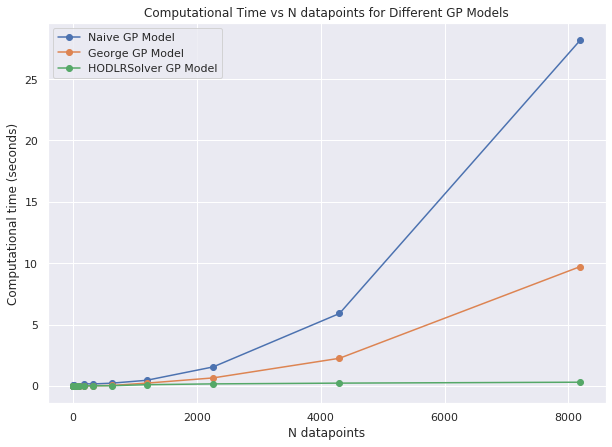

In [21]:
plt.figure(figsize = (10,7))
plt.plot(N, naive_time_list, 'o-', label = 'Naive GP Model')
plt.plot(N, george_time_list, 'o-', label = 'George GP Model')
plt.plot(N, HODLRSolver_time_list, 'o-', label = 'HODLRSolver GP Model')
plt.xlabel('N datapoints')
plt.ylabel('Computational time (seconds)')
plt.legend()
plt.title('Computational Time vs N datapoints for Different GP Models')

According to the paper 'Fast Direct Methods for Gaussian Processes', an n-dimensional gaussian processes model is dependent on the inversion of an n×n covariance matrix and the evaluation of the determinant. In an n-dimensional setting, this matrix is typically dense and both the matrix and its determinant requires $O(n^3)$ work. For large n, the cost of inverting the matrix is expensive. With George, the inversion for the covariance matrix requires $O(nlog^2n)$ work through hierarchical factorization which also directly calculates probabilities in high dimensions under fairly broad assumptions on the kernel. 

In [22]:
# deleting variables to conserve memory
del t, sig, tx, X_train, Y_train, mu_s, cov_s, samples, cv_loss_list, \
    l_list, t_obs, y_obs, sig_obs, uncertainty, err, gp, X, kernels, \
    naive_time_list, george_time_list, HODLRSolver_time_list, N

# Problem 2

## (a) 
Download the catalog of stars with periodic light curves attributed to rotation by McQuillan et al.
2014 (table 1)

In [23]:
from astroquery.vizier import Vizier

# KIC = star id, Prot = rotation period, Teff = effective temperature
data = Vizier(catalog = 'J/ApJS/211/24/table1', columns = ['KIC','Prot','Teff'],
              row_limit = float('inf'))
results = data.query_constraints()[0].to_pandas()

## (b) 
For the first 100 objects in the table, download their Kepler light curves (for all quarters). You can use
the kplr package.1 Use the “PDCSAP_FLUX” and its error. Explain briefly what this is and how it is
computed. How is it different from the raw flux? Rescale the fluxes and errors so that they have 0 mean and order unity variance. This will make the range of optimal kernel hyperparameters more constant
across all the light curves. Plot flux as a function of time for several objects. Rather than plotting the
full 4 years’ of data, set the time limits to be comparable to the characteristic evolution timescale, so
you can see a few periods. Show plots for the following KIC ids: 892376, 1026146, 1026474.

In [24]:
import kplr
client = kplr.API()

stars = np.array(results['KIC'][:100])
periods = np.array(results['Prot'][:100])

df_list = []
for star in stars:
    kplr = client.star(star)

    # Get a list of light curve datasets.
    lcs = kplr.get_light_curves(short_cadence=False)

    lc_df = pd.DataFrame()
    
    # Loop over the datasets and read in the data.
    for lc in range(len(lcs)):     
        hdu_data = lcs[lc].open()[1].data
        df = pd.DataFrame(hdu_data.newbyteorder().byteswap())
        # rescaling fluxes and errors
        df['PDCSAP_FLUX'] = (df['PDCSAP_FLUX'] - np.nanmean(df['PDCSAP_FLUX']))/np.nanmean(df['PDCSAP_FLUX_ERR'])
        df['PDCSAP_FLUX_ERR'] = df['PDCSAP_FLUX_ERR']/np.nanmean(df['PDCSAP_FLUX_ERR'])
        lc_df = pd.concat([lc_df,df])

    df_list.append(lc_df)  

In [25]:
# checking for the index of the stars that we want
for i in range(len(stars)):
    if stars[i] == 892376:
        print('892376 index :',i)
    elif stars[i] == 1026146:
        print('1026146 index :',i)
    elif stars[i] == 1026474:
        print('1026474 index :',i)

892376 index : 0
1026146 index : 1
1026474 index : 2


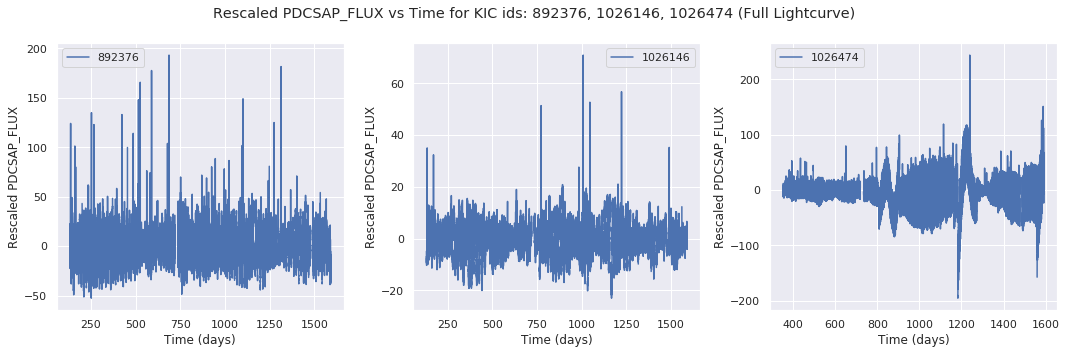

In [26]:
# plotting the full 4 years of data

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))
ax1.plot(df_list[0]['TIME'], df_list[0]['PDCSAP_FLUX'], label = '892376')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Rescaled PDCSAP_FLUX')
ax1.legend()
ax2.plot(df_list[1]['TIME'], df_list[1]['PDCSAP_FLUX'], label = '1026146')
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Rescaled PDCSAP_FLUX')
ax2.legend()
ax3.plot(df_list[2]['TIME'], df_list[2]['PDCSAP_FLUX'], label = '1026474')
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Rescaled PDCSAP_FLUX')
ax3.legend()
plt.tight_layout()
plt.suptitle('Rescaled PDCSAP_FLUX vs Time for KIC ids: 892376, 1026146, 1026474 (Full Lightcurve)')
f.subplots_adjust(top=0.88)
plt.show()

In [27]:
new_time1 = df_list[0][df_list[0]['TIME'] < 165]
new_time2 = df_list[1][df_list[1]['TIME'] < 250]
new_time3 = df_list[2][df_list[2]['TIME'] < 430]

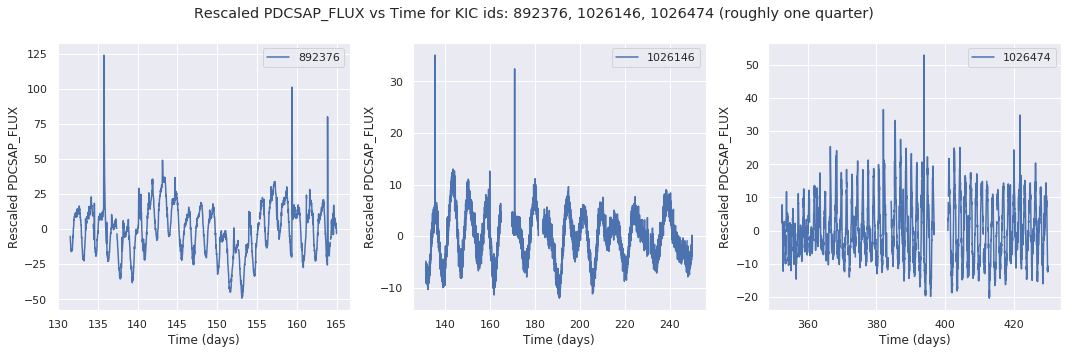

In [28]:
# plotting roughly 1 quarter fore each KIC ID

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,5))
ax1.plot(new_time1['TIME'], new_time1['PDCSAP_FLUX'], label = '892376')
ax2.plot(new_time2['TIME'], new_time2['PDCSAP_FLUX'], label = '1026146')
ax3.plot(new_time3['TIME'], new_time3['PDCSAP_FLUX'], label = '1026474')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Rescaled PDCSAP_FLUX')
ax1.legend()
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Rescaled PDCSAP_FLUX')
ax2.legend()
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Rescaled PDCSAP_FLUX')
ax3.legend()
plt.tight_layout()
plt.suptitle('Rescaled PDCSAP_FLUX vs Time for KIC ids: 892376, 1026146, 1026474 (roughly one quarter)')
f.subplots_adjust(top=0.88)
plt.show()

In [29]:
del new_time1, new_time2, new_time3

## (c) 
Do all light curves have clear periods? Plot an example of one light curve in which the period is visually
obvious, and one in which it is not (perhaps because the shape changes on a timescale comparable to
the period itself). Discuss what, astrophysically, causes the changes in light curve shape over time.

Not all lightcurves have clear periods. If you look in the 3 graphs above, you can see that KIC 892376 has a consistent sine-like lightcurve whereas KIC 1026146 and 1026474 do not have any consistent sine-like trend. According to Angus et al. 2018, spots move on the stellar surface and have finite lifetimes, which causes stellar flux variations to slowly shift in phase and result in non-sinusoidal lightcurves.

## (d) 
We’ll model the light curves using a quasi-period kernel, similar to a damped simple harmonic oscillator.
Explain the physical motivation for using this kind of kernel. The introduction of Angus et al. 2018
should be very relevant.

A perfect sinusoid would not be a good model choice as it would not accurately represent the complexities within the lightcurves and would not result in precise period recovery when conditioned on the data. It is important to use a quasi-period kernel as it captures the complicated surface spot patterns that produce non-sinusoidal variations. 

## (e)
A common problem when dealing with periodic signals is aliasing, which can cause false periods at
harmonics of the true period (i.e., 2P, P/2, etc.). Calculate and plot Lomb-Scargle periodograms for
a few stars. Do you see evidence of aliasing?

In [30]:
# getting rid of nan values in dataframes
df_list_dropna = []

for i in range(len(df_list)):
    df_list_dropna.append(df_list[i].dropna(axis=0, subset=['PDCSAP_FLUX']))


In [31]:
del df_list

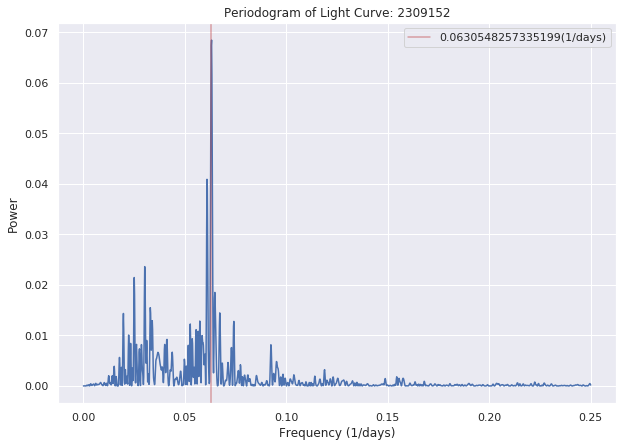

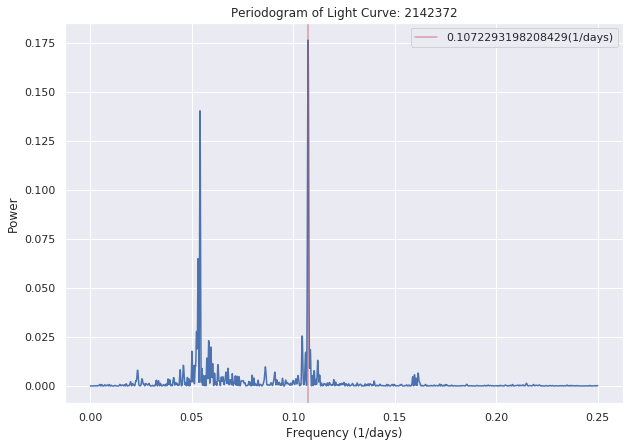

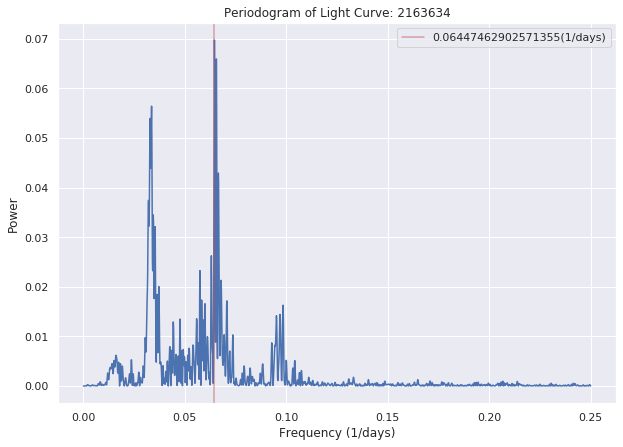

In [32]:
import random

# choosing 3 random stars
rand_index = random.sample(range(1, 100), 3)

for i in rand_index:
    
    freq, power = LombScargle(df_list_dropna[i]['TIME'], 
                              df_list_dropna[i]['PDCSAP_FLUX'],
                              df_list_dropna[i]['PDCSAP_FLUX_ERR']).autopower(maximum_frequency=.25,
                                                                              samples_per_peak=5)
    
    best_freq = freq[np.argmax(power[1:])]

    plt.figure(figsize=(10,7))
    plt.plot(freq, power)
    plt.axvline(x=best_freq, color = 'r', alpha = .5, label = '{}(1/days)'.format(best_freq))
    plt.title(f"Periodogram of Light Curve: {stars[i]}")
    plt.xlabel("Frequency (1/days)")
    plt.ylabel("Power")
    plt.legend()

In the above lightcurves, I do see signs of aliasing as there are consistent peaks at harmonics of the true period.

## (f) 
To minimize aliasing, we’ll use a kernel that is a sum of simple harmonic oscillators with periods P and
2P. A fast version of such a kernel is implemented in the exoplanet package.

In [33]:
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

def GP_model(x,y,yerr):
    
    # getting lombscargle as done by the exoplanet package tutorial
    results = xo.estimators.lomb_scargle_estimator(
        x, y, max_peaks=1, min_period=0.1, max_period=50.0, samples_per_peak=50
    )

    peak = results["peaks"][0]

    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0.0, sd=10.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2 * np.log(np.mean(yerr)), sd=2.0)

        # A term to describe the non-periodic variability
        logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y)), sd=5.0)
        logw0 = pm.Normal("logw0", mu=np.log(2 * np.pi / 10), sd=5.0)

        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
        BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
        logperiod = BoundedNormal("logperiod", mu=np.log(peak["period"]), sd=5.0)
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = xo.distributions.UnitUniform("mix")

        # Track the period as a deterministic
        period = pm.Deterministic("period", tt.exp(logperiod))

        # Set up the Gaussian Process model
        kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
        kernel += xo.gp.terms.RotationTerm(
            log_amp=logamp, period=period, log_Q0=logQ0, log_deltaQ=logdeltaQ, mix=mix
        )
        gp = xo.gp.GP(kernel, x, yerr ** 2)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y - mean))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())

        # Optimize to find the maximum a posteriori parameters
        map_soln = xo.optimize(start=model.test_point, method = 'trust-constr')

    del x,y,yerr,peak,mean,logs2,logSw4,logw0,logamp,BoundedNormal,logperiod,logQ0,logdeltaQ,mix,period,kernel  
    
    gc.collect()
        
    return map_soln, model, gp

In [34]:
x = np.ascontiguousarray(df_list_dropna[0]['TIME'], dtype=np.float64)
y = np.ascontiguousarray(df_list_dropna[0]['PDCSAP_FLUX'], dtype=np.float64)
yerr = np.ascontiguousarray(df_list_dropna[0]['PDCSAP_FLUX_ERR'], dtype=np.float64)

gp_map_soln, gp_model, gp = GP_model(x, y, yerr)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
184it [00:18,  8.75it/s, logp=-1.781163e+05]
message: `xtol` termination condition is satisfied.
logp: -493264.9485522623 -> -178116.29604711532


## (g) 
Implement a GP model for the full light curve of one of your objects using exoplanet and a sum of
two simple harmonic oscillators as a kernel. This kernel has several free parameters. One is the period,
P, which is one we care most about. Once you have a model, you can assess how “good” the model is
using a traditional goodness of fit indicator, such as χ
2
. You can then adjust the free parameters of the
kernel to maximize the likelihood (minimizing χ
2
, assuming Gaussian uncertainties). Carry out such
a fit for one of your light curves, either using one of the optimizers in scipy or the built-in optimizer
in exoplanet. How does your best-fit P compare to the estimate from McQuillan et al. 2014?

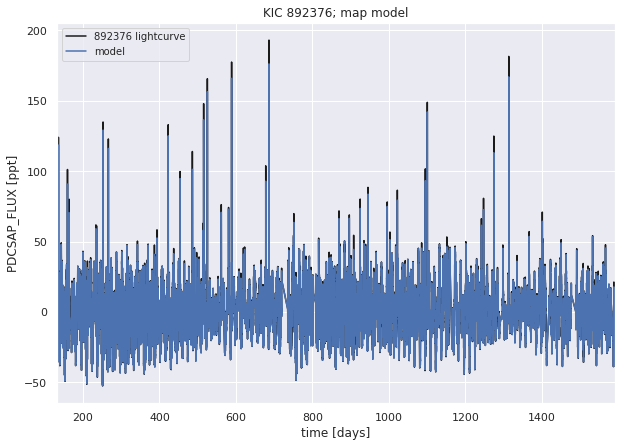

In [35]:
plt.figure(figsize=(10,7))
plt.plot(x, y, "k", label="892376 lightcurve")
plt.plot(x, gp_map_soln["pred"], label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("PDCSAP_FLUX [ppt]")
plt.title("KIC 892376; map model")
plt.show()

In [36]:
chisquare = cv_loss(gp_map_soln['pred'], y, gp_map_soln['logs2'], yerr)
print(f"ChiSquare value for exoplanet GP model: {chisquare}")
print("My best fit P: {} vs McQuillan et al. 2014's best fit P: {}".format(gp_map_soln['period'], periods[0]))

ChiSquare value for exoplanet GP model: 0.1298058324087265
My best fit P: 1.3915833862511613 vs McQuillan et al. 2014's best fit P: 1.531999945640564


My best fit P is very close to McQuillan et al. 2014's best fit P! Additionally, you can see with the plot above that the model fits to the data fairly well and yields a low chisquare value.

## (h) 
Assuming Gaussian uncertainties is not formally the right thing to do for light curves. Explain (i)
why this is, and (ii) why it’s still an acceptable approximation for Kepler data, and (iii) what a more
principled choice might be.

(referencing Angus et al. 2018)

(i) Assumming Gaussian uncertainties is not formally the right thing to do for light curves because assuming the uncertainties are uncorrelated suggests that the noise is 'white' and the off-diagonal elements of the covariance matrix are zero.

(ii) This is still an acceptable approximation for Kepler data because in the case where there is evidence for correlated noise, those off-diagonal elements are non-zero.

(iii) With GP regression, a covariance matrix generated by the kernel function replaces the covariance matrix.

## (i) 
You likely found that evaluating and optimizing the GP model with full Kepler light curves (which
have about 60,000 points) is fairly slow. The times-spacing of Kepler light curves is pretty dense. You
can likely get reasonably good measurements of periods with only a subset of these points, since the
periods of most rotating stars will be significantly longer than the typical exposure time. Try reducing
the number of points by (a) downsampling the data (i.e., taking only every N-th datapoint) and/or
(b) taking a shorter subset of the light curve instead of the full 4 years. How much sub-sampling can
you get away with before you period measurements get degraded? Justify your choice by plotting some
quantification of period accuracy versus how much you subsample. You can use whatever subsampling
you find to be appropriate for the rest of the lab.

In [37]:
# original values of x, y, yerr
x_og = np.ascontiguousarray(df_list_dropna[0]['TIME'], dtype=np.float64)
y_og = np.ascontiguousarray(df_list_dropna[0]['PDCSAP_FLUX'], dtype=np.float64)
yerr_og = np.ascontiguousarray(df_list_dropna[0]['PDCSAP_FLUX_ERR'], dtype=np.float64)

# trying a different number of subsets
N = np.linspace(10, 50, 5).astype(int)
# difference in periods to meausure accuracy
period_diff = []

for n in N:
    # getting subset of original values by taking every N-th datapoint
    x = x_og[::n]
    y = y_og[::n]
    yerr = yerr_og[::n]

    gp_map_soln, gp_model, gp = GP_model(x, y, yerr)
    per = gp_map_soln['period']
    period_diff.append(abs(per - periods[0]))

del x_og,y_og,yerr_og

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
404it [00:09, 44.07it/s, logp=-2.372244e+04]
message: The maximum number of function evaluations is exceeded.
logp: -63902.40586571081 -> -23722.438908677832
optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
336it [00:03, 96.80it/s, logp=-1.269322e+04] 
message: `xtol` termination condition is satisfied.
logp: -29727.06524535529 -> -12693.217054805156
optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
320it [00:03, 103.06it/s, logp=-7.673103e+03]
message: `xtol` termination condition is satisfied.
logp: -17780.081933488684 -> -7673.103079311431
optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
232it [00:01, 118.67it/s, logp=-5.922046e+03]
message: `xtol` termination condition is satisfied.
logp: -9920.928389743869 -> -5922.0455476873

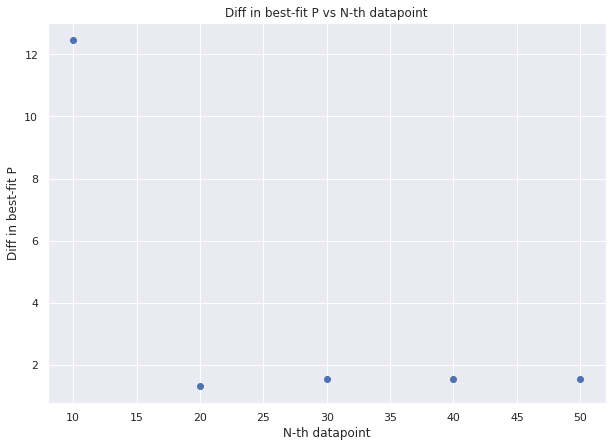

In [38]:
plt.figure(figsize = (10,7))
plt.scatter(N, period_diff)
plt.xlabel('N-th datapoint')
plt.ylabel('Diff in best-fit P')
plt.title('Diff in best-fit P vs N-th datapoint')
plt.show()
del N

I used the difference in my best-fit P versus McQuillan et al 2014's best fit P to measure the period accuracy for each subsample. According to the graph above, every 20th point and beyond yield similar accuracies so I decided to make my subsample every 20th datapoint.

## (j)
To get uncertainties on P (and other kernel parameters), we can use MCMC. Using pymc3 and the same
likelihood function as in part (g), with the addition of sensible priors, sample from the posterior of kernel
parameters. Make some diagnostic plots to verify that your sampler has converged. Use corner.py to
visualize your parameter constraints. Note: due to the large plausible dynamic range, sampling (and
optimization) will likely be more efficient if you sample in the log of the kernel parameters.

In [39]:
def MCMC(x, y, yerr):
    
    # getting lombscargle as done by the exoplanet package tutorial
    results = xo.estimators.lomb_scargle_estimator(
        x, y, max_peaks=1, min_period=1.0, max_period=50.0, samples_per_peak=50
    )

    peak = results["peaks"][0]
    freq, power = results["periodogram"]
    
    map_soln, model, gp = GP_model(x, y, yerr)
    with gp_model:

        # Sample from the posterior using the sampling method
        trace = pm.sample(tune=500,
                          draws=500,
                          start=map_soln,
                          step=xo.get_dense_nuts_step(target_accept=0.9))
    gc.collect()
    return trace

In [40]:
x = np.ascontiguousarray(df_list_dropna[0]['TIME'][::20], dtype=np.float64)
y = np.ascontiguousarray(df_list_dropna[0]['PDCSAP_FLUX'][::20], dtype=np.float64)
yerr = np.ascontiguousarray(df_list_dropna[0]['PDCSAP_FLUX_ERR'][::20], dtype=np.float64)

mcmc_model = MCMC(x, y, yerr)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
336it [00:03, 105.39it/s, logp=-1.269322e+04]
message: `xtol` termination condition is satisfied.
logp: -29727.06524535529 -> -12693.217054805156
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [04:14<00:00, 12.32draws/s]


In [41]:
variables = ["mix", "logdeltaQ", "logQ0", "logperiod", "logamp", "logSw4", "logw0", "logs2", "mean"]
pm.summary(mcmc_model, varnames= variables)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mix,0.678,0.189,0.354,0.989,0.005,0.004,1325.0,1263.0,1175.0,877.0,1.00
logdeltaQ,-3.785,6.684,-16.330,6.252,0.195,0.146,1174.0,1052.0,1136.0,1214.0,1.01
logQ0,6.626,0.494,5.739,7.473,0.015,0.011,1148.0,1032.0,1585.0,1036.0,1.00
logperiod,1.120,0.000,1.120,1.121,0.000,0.000,2000.0,2000.0,2003.0,1329.0,1.00
logamp,4.663,0.523,3.822,5.552,0.017,0.013,936.0,787.0,1389.0,1007.0,1.00
logSw4,5.823,0.087,5.665,5.988,0.002,0.001,1717.0,1717.0,1728.0,1316.0,1.00
logw0,0.124,0.033,0.060,0.184,0.001,0.001,1930.0,1850.0,1927.0,1461.0,1.00
logs2,-0.035,1.930,-3.745,3.485,0.054,0.043,1297.0,1030.0,1312.0,1263.0,1.00
mean,0.185,0.527,-0.768,1.223,0.014,0.011,1473.0,1198.0,1475.0,1215.0,1.00


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b42ece400>,
      dtype=object)

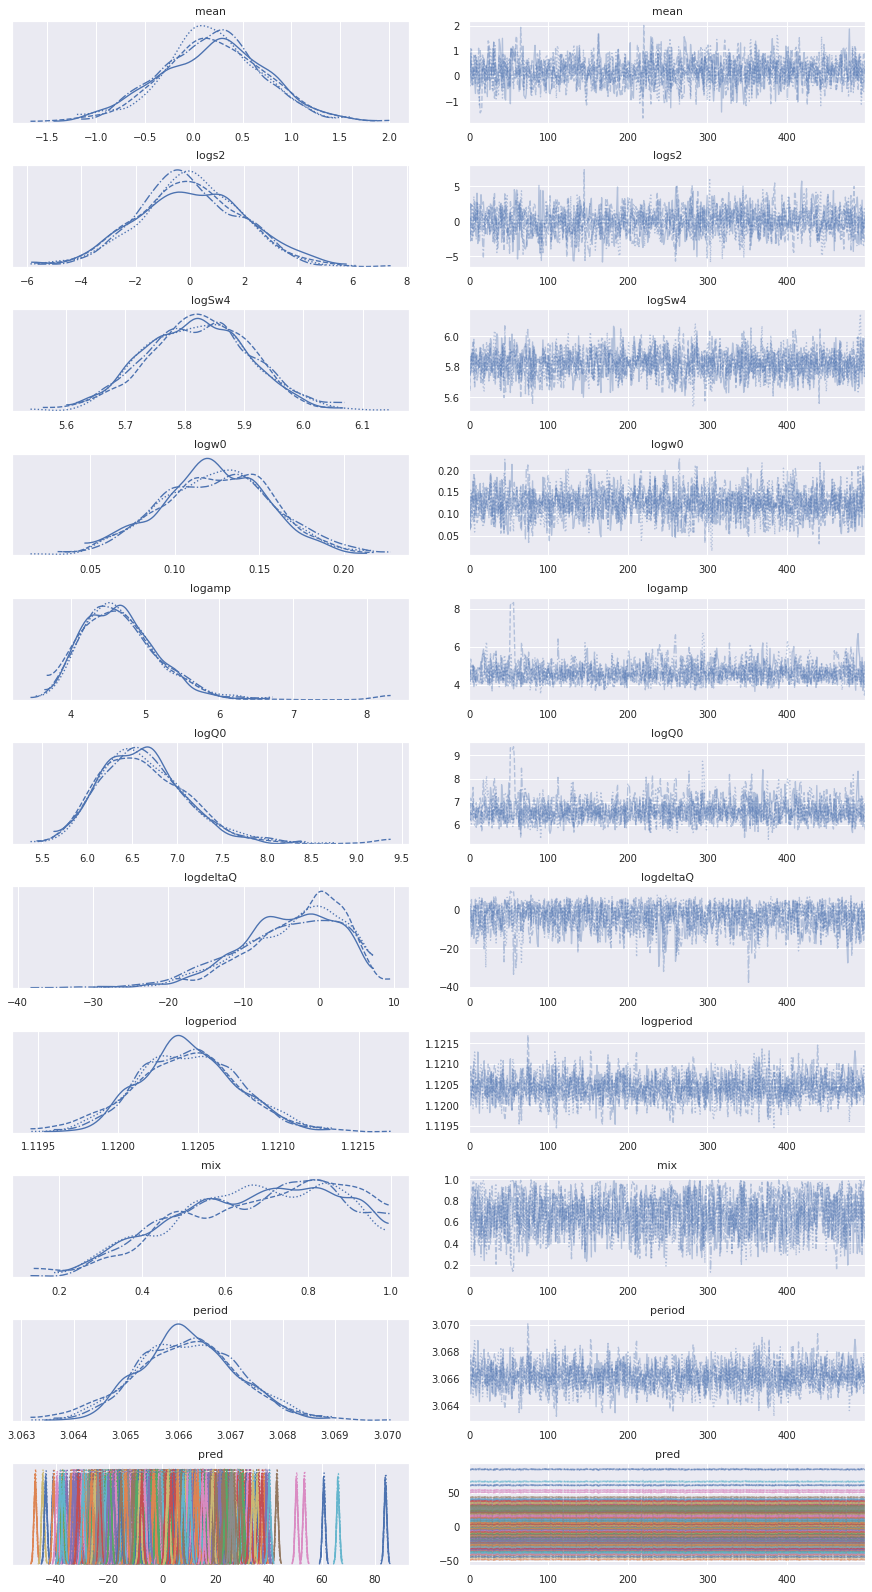

In [42]:
pm.traceplot(mcmc_model)

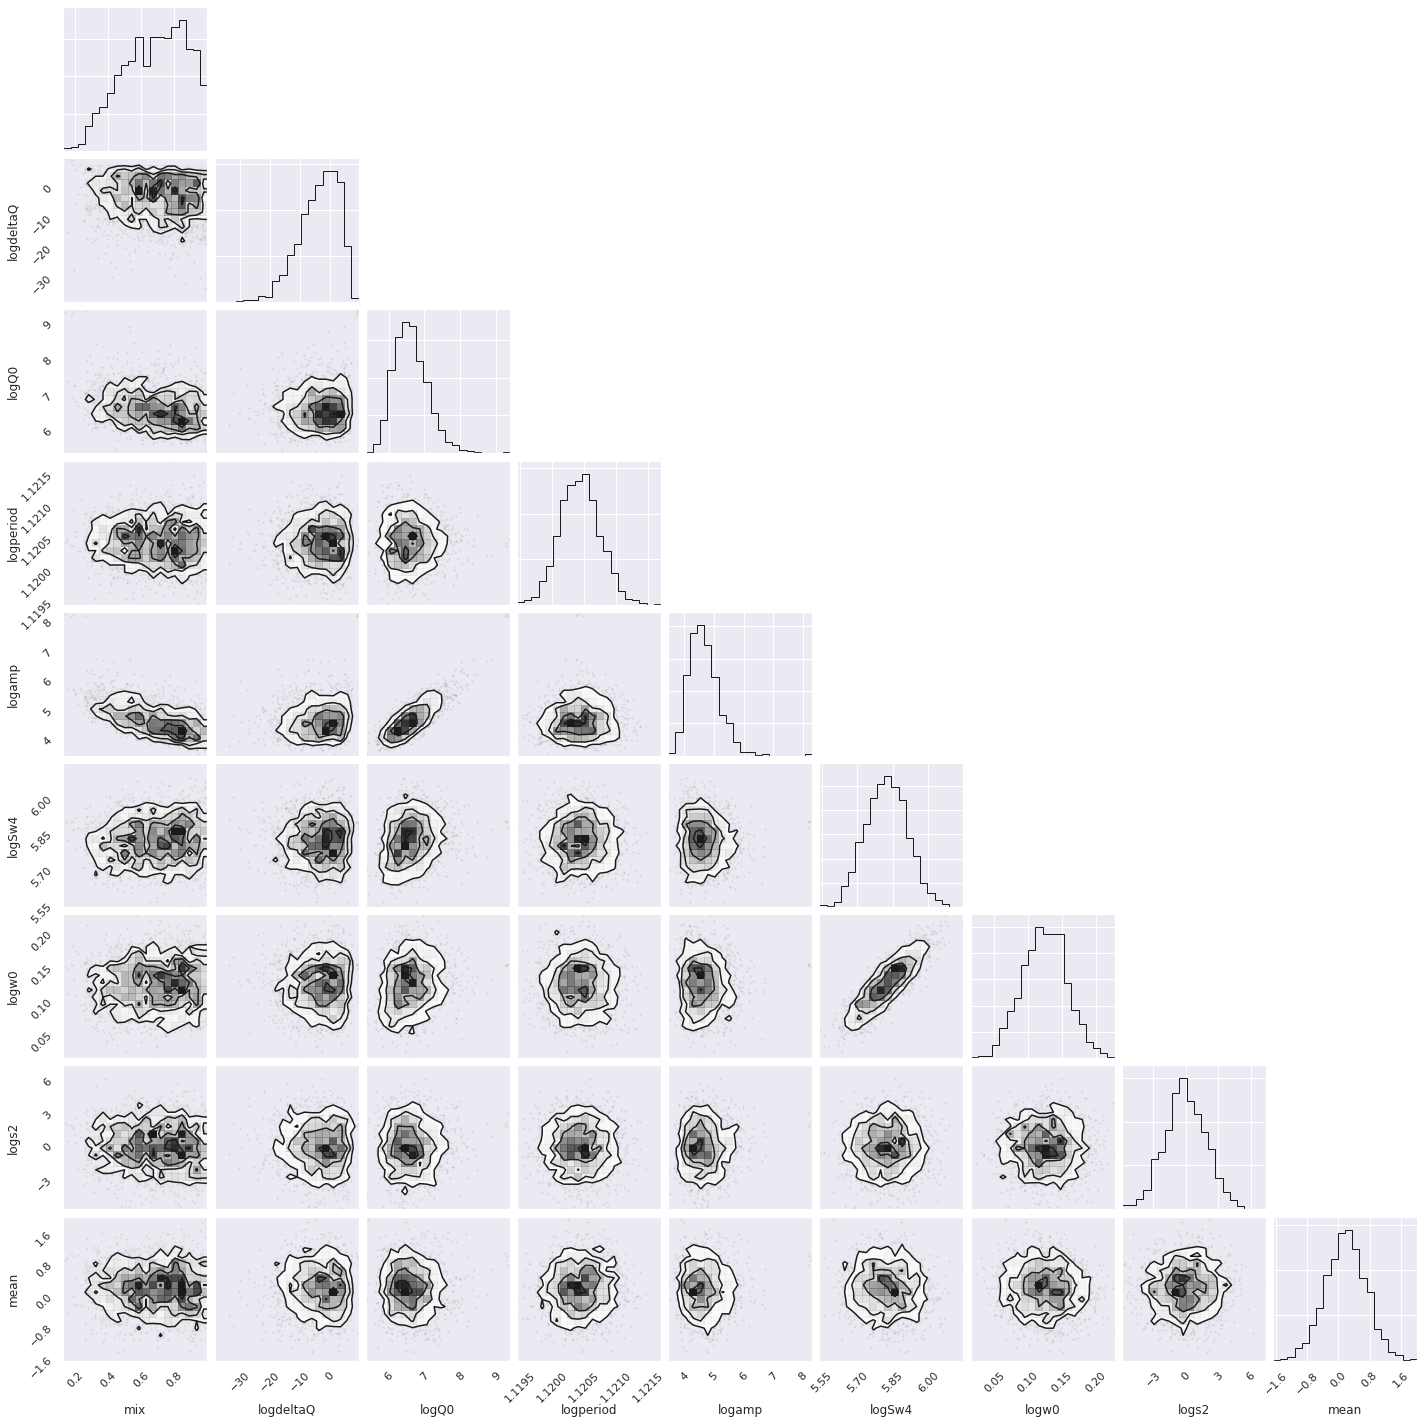

In [43]:
import corner
samples = np.vstack([mcmc_model[k] for k in variables]).T
fig = corner.corner(samples, labels=variables)

## (k) 
Once you have a well-fit GP model of a light curve, you can use it to predict the light curve where
there is no data. Kepler light curves all have gaps, due to periods when the telescope was downlinking
data, and other technical glitches. Let’s examine one of these gaps and plot the model prediction and
uncertainty. Consider the light curve of KIC 892376 over 700 < t < 770. First, plot the prediction
and 1σ uncertainties for the maximum-likehoood model found in part (g). Then repeat this on a separate plot, now plotting predictions for models with different kernel hyperparameters drawn from
the samples obtained in part (j). Comment. Do these two approaches yield comparable uncertainties
in the prediction? How can you interpret the difference between the maximum-likelihood and MCMC
uncertainties?

In [44]:
# repeated from part (g) now using subsample
x = np.ascontiguousarray(df_list_dropna[0]['TIME'][::20], dtype=np.float64)
y = np.ascontiguousarray(df_list_dropna[0]['PDCSAP_FLUX'][::20], dtype=np.float64)
yerr = np.ascontiguousarray(df_list_dropna[0]['PDCSAP_FLUX_ERR'][::20], dtype=np.float64)

gp_map_soln, gp_model, gp = GP_model(x, y, yerr)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
336it [00:02, 115.61it/s, logp=-1.269322e+04]
message: `xtol` termination condition is satisfied.
logp: -29727.06524535529 -> -12693.217054805156


In [45]:
exclude_keys = ['pred']
map_soln = {k: gp_map_soln[k] for k in set(list(gp_map_soln.keys())) - set(exclude_keys)}
map_soln

{'mix_logodds__': array(0.75467727),
 'logSw4': array(4.31876196),
 'logs2': array(-3.12681796e-06),
 'logperiod': array(1.0496054),
 'mean': array(0.04368802),
 'mix': array(0.680197),
 'logQ0': array(1.01306306),
 'logdeltaQ': array(16.15440587),
 'logperiod_interval__': array(-1.0032523),
 'period': array(2.85652371),
 'logamp': array(5.19977282),
 'logw0': array(-0.31049907)}

In [46]:
t_pred = np.linspace(715,740,500)

with gp_model: 
    predict = gp.predict(t_pred, return_var=True)
    gc.collect()
    mu, var = xo.utils.eval_in_model(predict, map_soln)
    gc.collect()


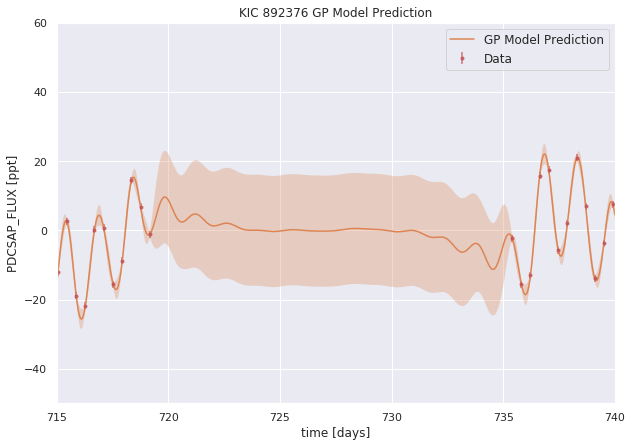

In [47]:
# plot made using model from part (g)

plt.figure(figsize=(10,7))
# Plot the prediction and the 1-sigma uncertainty
sd = np.sqrt(var)
art = plt.fill_between(t_pred, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
plt.plot(t_pred, mu, color="C1", label="GP Model Prediction")
plt.errorbar(x,y,yerr,fmt='ro',label='Data',alpha=.75,markersize=3)
plt.xlim(715,740)
plt.ylim(-50,60)
plt.legend(fontsize=12)
plt.xlabel("time [days]")
plt.ylabel("PDCSAP_FLUX [ppt]")
plt.title("KIC 892376 GP Model Prediction")
plt.show()


In [48]:
del samples

In [49]:
# repeated from part (j)
N_pred = 10
pred_mu = np.empty((N_pred, len(t_pred)))
pred_var = np.empty((N_pred, len(t_pred)))

with gp_model:
     for i, sample in enumerate(xo.get_samples_from_trace(mcmc_model, size=N_pred)):
        pred_mu[i], pred_var[i] = xo.eval_in_model(predict, sample)

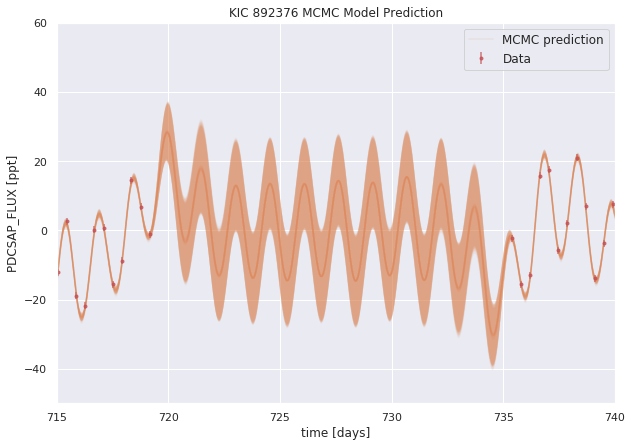

In [50]:
plt.figure(figsize=(10,7))
for i in range(len(pred_mu)):
    mu = pred_mu[i]
    sd = np.sqrt(pred_var[i])
    label = None if i else "MCMC prediction"
    art = plt.fill_between(t_pred, mu + sd, mu - sd, color="C1", alpha=0.1)
    art.set_edgecolor("none")
    plt.plot(t_pred, mu, color="C1", label=label, alpha=0.1)

plt.errorbar(x,y,yerr,fmt='ro',label='Data',alpha=.75,markersize=3)
plt.xlim(715,740)
plt.ylim(-50,60)
plt.legend(fontsize=12)
plt.xlabel("time [days]")
plt.ylabel("PDCSAP_FLUX [ppt]")
plt.title("KIC 892376 MCMC Model Prediction")
plt.show()

My MCMC Model yields much better results than my GP model

## (l) 
Now take the first 100 stars in table 1 and fit a GP model to estimate the rotation period, P. Use
whatever sub-sampling scheme you found to work in part (i). Just using an optimizer is OK here; no
need for full MCMC. Make a plot comparing your best-fit periods to those reported by McQuillan et
al. 2014, on a log scale. Comment on the origin of any discrepancies.

In [51]:
period_list = []
for i in range(len(stars)):
    x = np.ascontiguousarray(df_list_dropna[i]['TIME'][::20], dtype=np.float64)
    y = np.ascontiguousarray(df_list_dropna[i]['PDCSAP_FLUX'][::20], dtype=np.float64)
    yerr = np.ascontiguousarray(df_list_dropna[i]['PDCSAP_FLUX_ERR'][::20], dtype=np.float64)

    gp_map_soln, gp_model, gp = GP_model(x, y, yerr)
        
    period_list.append(gp_map_soln["period"])

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
336it [00:03, 109.29it/s, logp=-1.269322e+04]
message: `xtol` termination condition is satisfied.
logp: -29727.06524535529 -> -12693.217054805156
optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
144it [00:01, 89.51it/s, logp=-6.498013e+03] 
message: `xtol` termination condition is satisfied.
logp: -7828.0330760502475 -> -6498.0126178936935
optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
300it [00:02, 105.44it/s, logp=-1.245070e+04]
message: `xtol` termination condition is satisfied.
logp: -40384.70534797959 -> -12450.703832638312
optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
134it [00:01, 88.48it/s, logp=-6.267986e+03] 
message: `xtol` termination condition is satisfied.
logp: -7173.658331990104 -> -6267.986403824358
optimizi

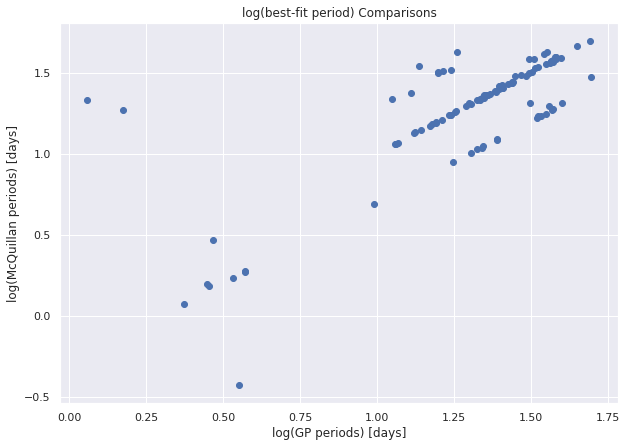

In [52]:
plt.figure(figsize = (10,7))
plt.scatter(np.log10(period_list), np.log10(periods))
plt.xlabel('log(GP periods) [days]')
plt.ylabel('log(McQuillan periods) [days]')
plt.title('log(best-fit period) Comparisons')
plt.show()

Compared to the best-fit periods of those reported by McQuillan et al. 2014 I notice some period halving and even less period doubling.

## (m) 
Once you are convinced your period-finding scheme is robust (which hopefully will mean you get the
same period as McQuillan et al. in a majority of cases), try fitting the light curves of all stars in a
narrow temperature range, 3600 < Teff/K < 3650. Plot a histogram of the rotation periods you obtain,
and overplot a histogram of the McQuillan et al. periods for the same stars. One of the main claims in
the McQuillan paper is that the period distribution is bimodal at fixed temperature. Do you still find a
bimodal distribution when using your periods? Discuss what, physically, a bimodal period distribution
might imply.

In [53]:
temp_range = results['Teff'][results['Teff'] > 3600]
temp_range = temp_range[temp_range < 3650]
stars = np.array(results['KIC'][temp_range])
periods = np.array(results['Prot'][temp_range])

In [54]:
import kplr
client = kplr.API()

df_list = []
for star in stars:
    print('Loading star {}'.format(star))
    kplr = client.star(star)

    # Get a list of light curve datasets.
    lcs = kplr.get_light_curves(short_cadence=False)

    lc_df = pd.DataFrame()
    
    # Loop over the datasets and read in the data.
    for lc in range(len(lcs)):     
        hdu_data = lcs[lc].open()[1].data
        df = pd.DataFrame(hdu_data.newbyteorder().byteswap())
        # getting rid of nan values in dataframe
        df = df.dropna(axis=0, subset=['PDCSAP_FLUX']) 
        # rescaling fluxes and errors
        df['PDCSAP_FLUX'] = (df['PDCSAP_FLUX'] - np.mean(df['PDCSAP_FLUX']))/np.mean(df['PDCSAP_FLUX_ERR'])
        df['PDCSAP_FLUX_ERR'] = df['PDCSAP_FLUX_ERR']/np.mean(df['PDCSAP_FLUX_ERR'])
        lc_df = pd.concat([lc_df,df])

    df_list.append(lc_df) 

Loading star 9292640
Loading star 9286422
Loading star 9301954
Loading star 9291325
Loading star 9291325
Loading star 9306231
Loading star 9272356
Loading star 9335198
Loading star 9326593
Loading star 9326184
Loading star 9334481
Loading star 9303651
Loading star 9283623
Loading star 9284485
Loading star 9339525
Loading star 9304752
Loading star 9335898
Loading star 9282882
Loading star 9334481
Loading star 9335898
Loading star 9334481
Loading star 9306231
Loading star 9284206
Loading star 9326184
Loading star 9286422
Loading star 9328136
Loading star 9339525
Loading star 9289069
Loading star 9326053
Loading star 9273730
Loading star 9327921
Loading star 9291325
Loading star 9284819
Loading star 9301392
Loading star 9283820
Loading star 9339297
Loading star 9339525
Loading star 9305907
Loading star 9289250
Loading star 9333505
Loading star 9339525
Loading star 9326053
Loading star 9303651
Loading star 9292640
Loading star 9286422
Loading star 9328224
Loading star 9333505
Loading star 

In [55]:
period_list = []
for i in range(len(stars)):
    x = np.ascontiguousarray(df_list[i]['TIME'][::20], dtype=np.float64)
    y = np.ascontiguousarray(df_list[i]['PDCSAP_FLUX'][::20], dtype=np.float64)
    yerr = np.ascontiguousarray(df_list[i]['PDCSAP_FLUX_ERR'][::20], dtype=np.float64)

    gp_map_soln, gp_model, gp = GP_model(x, y, yerr)
        
    period_list.append(gp_map_soln["period"])

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
144it [00:02, 64.40it/s, logp=-6.168901e+03] 
message: `xtol` termination condition is satisfied.
logp: -7089.6399159976 -> -6168.901005718009
optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
156it [00:02, 64.06it/s, logp=-5.964485e+03]
message: `xtol` termination condition is satisfied.
logp: -6598.867760274671 -> -5964.485485572502
optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
216it [00:02, 78.36it/s, logp=-5.573084e+03] 
message: `xtol` termination condition is satisfied.
logp: -6166.048161968236 -> -5573.083807361767
optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
148it [00:01, 81.47it/s, logp=-6.773113e+03] 
message: `xtol` termination condition is satisfied.
logp: -9353.353978763187 -> -6773.1134432925755
optimizing log

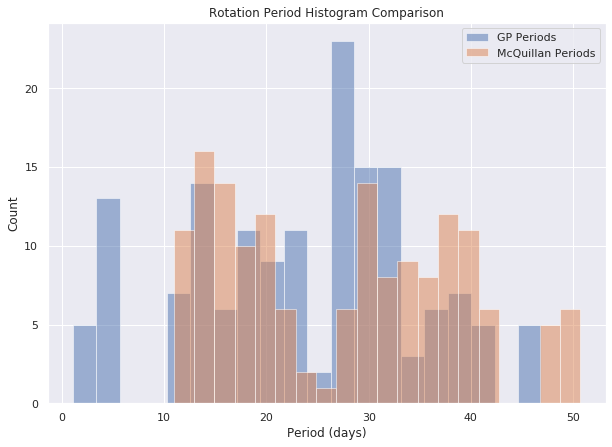

In [56]:
plt.figure(figsize=(10,7))
# plt.xlim(0,60)
plt.hist(period_list, bins=20, label='GP Periods',alpha=.5)
plt.hist(periods, bins=20, label='McQuillan Periods',alpha=.5)
plt.xlabel('Period (days)')
plt.ylabel('Count')
plt.title('Rotation Period Histogram Comparison')
plt.legend()
plt.show()

I notice a bimodal distribution when using my periods. A bimodal period distribution might imply that the stars are low-mass stars since this effect becomes less apparent towards higher masses since they probe a larger region of space. This might also imply two epochs of star formation in the solar neighborhood, or the star formation rate is unimodal but the spin-down occurs as two slow stages with a rapid stage in between. (McQuillan et al. 2014)

## (n) 
At least under certain conditions, the rotation period of a star can be used to constrain its age.
Measuring ages of stars from rotation periods is called “gyrochronology”. Why does this (sometimes)
work, and what are the conditions under which it is expected to work? When might it not work?

Gyochronology uses the rotation period and the color of a star in order to determine its age and mass. However, the rotation period must be a steadily changing and tight function of its age and color. Gyrochronology does not work well for younger stars that have not yet begun burning fuel at the steady rate like the majority of main-sequence stars, and does not work well for the stars that have left the main sequence.

## (o) 
Use the empirical color – rotation period – age relation from Meibomb et al. 2009 (specifically, the
functional form proposed by Barnes 2007, with free parameters calibrated to M35) to estimate ages of
the sample of stars whose periods you fit in part (m). Plot period versus color for a range of ages as
predicted by this model, and then plot age versus period for stars in the narrow temperature range you
are considering. You can estimate the color corresponding to this temperature range using isochrones.
Assuming most stars are on the main sequence, what mass does this color and temperature range
correspond to?
Plot the inferred age distribution. What can you infer about the age of the Galactic disk? Is the
age of the oldest stars you find similar to what you might expect given what we know about the Milky
Way? If not, what might account for this?

In [57]:
def barnes(t, color):
    c = 0.77
    d = 0.40
    f = 0.60
    P = (t**0.52) * ((c*(color - d))**f)
    return P

In [58]:
# [Fe/H] = 0, # age = 10,000 years
isocmd = read_mist_models.ISOCMD('MIST_iso_5e7e3e8283d01.iso.cmd')

Reading in: MIST_iso_5e7e3e8283d01.iso.cmd


In [59]:
Teff= isocmd.isocmds[0]['log_Teff']
Teff = 10**Teff
BV = isocmd.isocmds[0]['Swift_B']-isocmd.isocmds[0]['Swift_V']
mass= isocmd.isocmds[0]['star_mass']

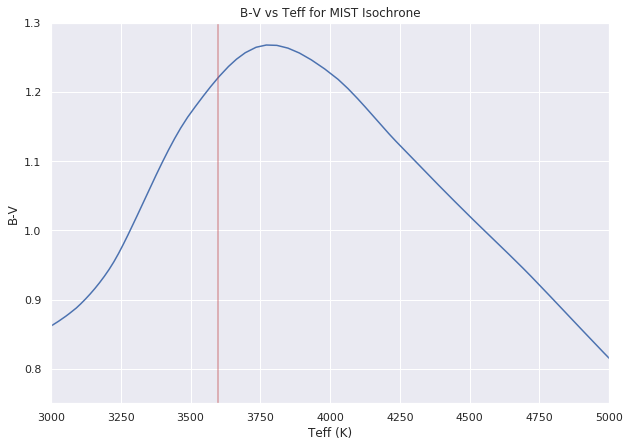

In [60]:
plt.figure(figsize=(10,7))
plt.plot(Teff, BV)
plt.axvline(3600, color = 'r', alpha = .5)
plt.xlim(3000,5000)
plt.ylim(0.75,1.3)
plt.xlabel('Teff (K)')
plt.ylabel('B-V')
plt.title('B-V vs Teff for MIST Isochrone')
plt.show()

In [61]:
Trange = Teff[Teff >= 3600]
Trange = Trange[Trange <= 3650]
mrange1 = mass[Teff == Trange[0]]
mrange2 = mass[Teff == Trange[1]]
print(f'At ~3600K, B-V = 1.22 and the corresponding mass range is {mrange1} < m < {mrange2}')

At ~3600K, B-V = 1.22 and the corresponding mass range is [0.35262497] < m < [0.36637706]


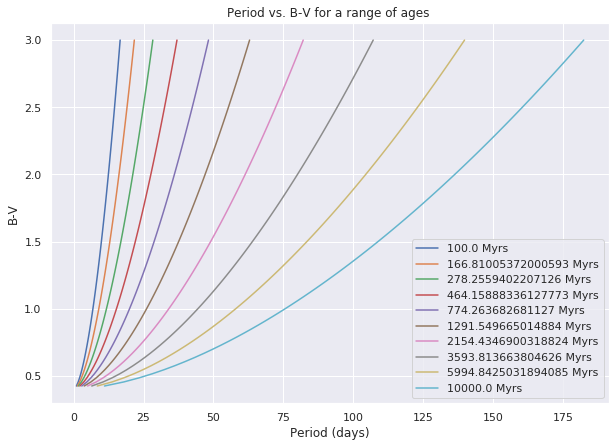

In [62]:
# plotting period versus color for a range of ages

t_list = np.logspace(2,4,10)
bv_list = np.linspace(0,3,100)

plt.figure(figsize=(10,7))
for t in t_list:
    plt.plot(barnes(t, bv_list), bv_list, label =f'{t} Myrs')
plt.xlabel('Period (days)')
plt.ylabel('B-V')
plt.legend()
plt.title('Period vs. B-V for a range of ages ')
plt.show()

In [63]:
# getting age from period

def invbarnes(P, color):
    c = 0.77
    d = 0.40
    f = 0.60
    t =(P / (c*(color-d)**f))**(1/0.52)
    return t

In [67]:
np.array(period_list)

array([36.19043043, 26.88691266, 30.00022164, 19.28879297, 19.28879297,
       33.05061396, 39.96072116, 14.03710388, 17.87733339, 16.29741027,
       30.21800738, 28.51018796, 12.12164188, 22.12391895, 14.52513302,
       18.18112058,  4.94315623, 20.97538449, 30.21800738,  4.94315623,
       30.21800738, 33.05061396, 40.55287701, 16.29741027, 26.88691266,
       27.20118   , 14.52513302, 22.29726289, 33.81768902, 13.71615043,
        4.14925433, 19.28879297, 11.13537442, 27.92688368, 20.25956953,
       22.89156024, 14.52513302, 24.24776124, 20.80802207, 38.26663159,
       14.52513302, 33.81768902, 28.51018796, 36.19043043, 26.88691266,
       38.22608867, 38.26663159, 20.80802207, 32.31306683, 19.28879297,
       27.4801325 , 41.27283879,  1.14843742,  1.07668768,  4.76897587,
       27.92688368, 11.13537442, 39.96072116, 18.18112058, 38.26663159,
       27.4801325 ,  4.14925433, 39.96072116, 22.89156024, 22.12391895,
       19.28879297, 27.4801325 , 14.52513302, 24.24776124,  4.94

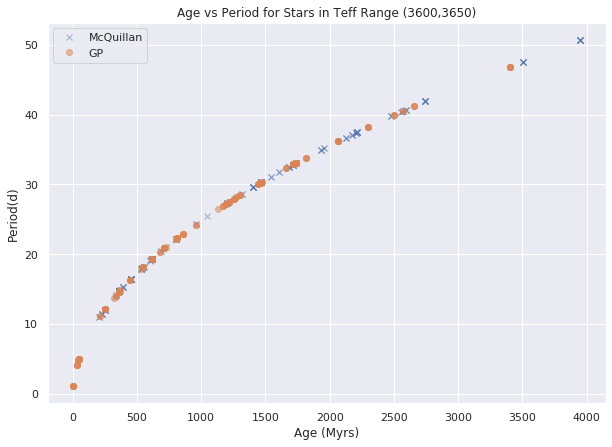

In [70]:
# plotting age versus period for stars in the narrow temperature range

BV = 1.22
age = np.logspace(2,4,100)

plt.figure(figsize=(10,7))
# plt.plot(age, barnes(age,BV), label='Model')
plt.plot(invbarnes(periods, BV), periods, 'x', label='McQuillan', alpha=.5)
plt.plot(invbarnes(np.array(period_list), BV), period_list, 'o', label='GP', alpha=.5)
plt.xlabel('Age (Myrs)')
plt.ylabel('Period(d)')
plt.title('Age vs Period for Stars in Teff Range (3600,3650)')
plt.legend()
plt.show()

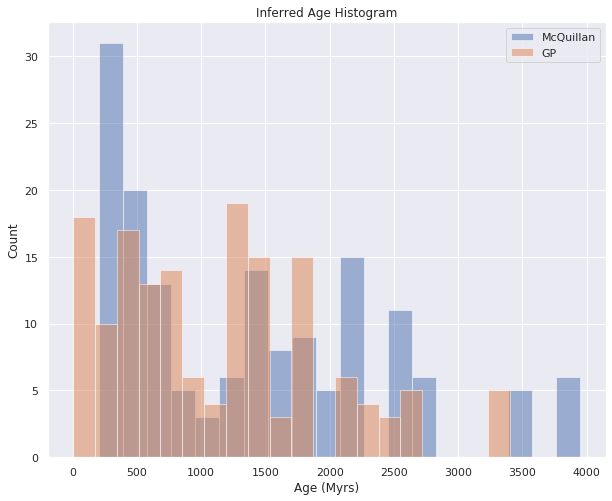

In [73]:
# plotting the inferred age distribution

plt.figure(figsize=(10,8))
plt.hist(invbarnes(periods, BV),bins=20, label='McQuillan', alpha=.5)
plt.hist(invbarnes(np.array(period_list), BV), bins=20, label='GP',alpha=.5)
plt.title('Inferred Age Histogram')
plt.xlabel('Age (Myrs)')
plt.ylabel('Count')
plt.legend()
plt.show()

We can infer that the age of the Galactic disk is fairly young. The age of the oldest stars aren't similar to what I might expect given what we know about the Milky Way (according to Wikipedia, the age of individual stars in the Milky Way yield values between 12-13 billion years, which is way larger than the ages we found here). This might be because of the number of fast-rotating stars or because of the quasi-periodic lightcurves.

## (p) 
You likely found that some stars have short rotation periods (P < 1 week), which would imply very
young ages. There are significantly more of these fast-rotating stars than predicted from age–rotation
rate models, given other constraints on the Milky Way’s recent star formation history. Check out
Simonian et al. 2018 for an investigation of this issue, and briefly discuss the proposed solution. Now also read through Section 5 of Meibom et al. 2009. What is *their* proposed explanation
from the rapidly-rotating low-mass stars? Are the two papers’ explanations compatible?

Simonian et al. 2018 propose that the excess of binaries among rapid
rotators is a sign that tidally-synchronized binaries dominate the short-period end of the rotation distribution. They found that the rapid rotators are consistent with being synchronized, non-eclipsing binary systems showing starspot modulation, up to periods of 7 days. This hypothesis can be tested using time-resolved moderate-resolution spectroscopy. If these systems were truly synchronized, the RV-derived orbital
period should be identical to the photometric rotation
period.

Meibomb et al. 2009 proposes that the rapidly rotating stars low-mass stars have radiative cores and convective envelopes that are decoupled. They suggest that their rotation rates are governed by the moments of inertia of the convective envelope and by inefficient wind-driven loss of angular momentum linked to small-scale convective magnetic fields. Higher mass stars have thinner convective envelopes with smaller moments of inertia than low-mass stars and thus leave the C sequence sooner. Stars that are either fully radiative or fully convective will remain as rapid rotators. The two papers' explanations are very different as one talks about tidally-synchornized binaries whereas the other proposes radiative cores and convective envelopes, and the explanations are therefore incompatible.